# Zugriffsdaten-Analyse

In diesem Notebook analysieren wir eine Logdatei mit Zugriffsdaten eines Webserver von einem iranischen Online-Shop. Wir wollen anhand der Zugriffsdaten herausfinden, welche Produkte des Online-Shops am beliebtesten sind. Außerdem untersuchen wir die Daten auf weitere Auffälligkeiten.

## Setup

Als erstes verbinden wir uns mit dem Spark Master Node. Den erreichen wir unter der URL `spark://localhost:7077`.

In [ ]:
import pyspark
from pyspark.sql.functions import *

spark = pyspark.sql.SparkSession.builder.appName("main") \
  .master("spark://localhost:7077") \
  .config("spark.executor.memory", "5G") \
  .getOrCreate()

## Datenimport

Als nächstes importieren wir die Datei `access.log`.

In [2]:
raw_df = spark.read.csv("/tmp/data/access.log", sep=" ")

In [ ]:
raw_df.count()

In [3]:
raw_df.rdd.getNumPartitions()

27

In [20]:
raw_df.show(5)

+-------------+---+---+--------------------+------+--------------------+---+-----+--------------------+--------------------+----+
|          _c0|_c1|_c2|                 _c3|   _c4|                 _c5|_c6|  _c7|                 _c8|                 _c9|_c10|
+-------------+---+---+--------------------+------+--------------------+---+-----+--------------------+--------------------+----+
| 54.36.149.41|  -|  -|[22/Jan/2019:03:5...|+0330]|GET /filter/27|13...|200|30577|                   -|Mozilla/5.0 (comp...|   -|
|  31.56.96.51|  -|  -|[22/Jan/2019:03:5...|+0330]|GET /image/60844/...|200| 5667|https://www.zanbi...|Mozilla/5.0 (Linu...|   -|
|  31.56.96.51|  -|  -|[22/Jan/2019:03:5...|+0330]|GET /image/61474/...|200| 5379|https://www.zanbi...|Mozilla/5.0 (Linu...|   -|
|40.77.167.129|  -|  -|[22/Jan/2019:03:5...|+0330]|GET /image/14925/...|200| 1696|                   -|Mozilla/5.0 (comp...|   -|
|  91.99.72.15|  -|  -|[22/Jan/2019:03:5...|+0330]|GET /product/3189...|200|41483|        

Die Kopfzeile der `DataFrame`-Tabelle enthält noch keine sinnvollen Bezeichnungen. Das wollen wir jetzt ändern.

In [3]:
df = raw_df.withColumnRenamed("_c0", "ip") \
  .drop("_c1") \
  .withColumnRenamed("_c2", "user") \
  .withColumnRenamed("_c3", "timestamp") \
  .withColumnRenamed("_c4", "timezone") \
  .withColumnRenamed("_c5", "request_line") \
  .withColumnRenamed("_c6", "status") \
  .withColumnRenamed("_c7", "bytes_sent") \
  .withColumnRenamed("_c8", "referer") \
  .withColumnRenamed("_c9", "user_agent") \
  .drop("_c10")

In [24]:
df.show(5)

+-------------+----+--------------------+--------+--------------------+------+----------+--------------------+--------------------+
|           ip|user|           timestamp|timezone|        request_line|status|bytes_sent|             referer|          user_agent|
+-------------+----+--------------------+--------+--------------------+------+----------+--------------------+--------------------+
| 54.36.149.41|   -|[22/Jan/2019:03:5...|  +0330]|GET /filter/27|13...|   200|     30577|                   -|Mozilla/5.0 (comp...|
|  31.56.96.51|   -|[22/Jan/2019:03:5...|  +0330]|GET /image/60844/...|   200|      5667|https://www.zanbi...|Mozilla/5.0 (Linu...|
|  31.56.96.51|   -|[22/Jan/2019:03:5...|  +0330]|GET /image/61474/...|   200|      5379|https://www.zanbi...|Mozilla/5.0 (Linu...|
|40.77.167.129|   -|[22/Jan/2019:03:5...|  +0330]|GET /image/14925/...|   200|      1696|                   -|Mozilla/5.0 (comp...|
|  91.99.72.15|   -|[22/Jan/2019:03:5...|  +0330]|GET /product/3189...|   20

Dann sollten wir noch die Inhalte innerhalb der Zellen bereinigen. Momentan werden leere Zellen mit einem Bindestrich gekennzeichnet. Wir wollen diese Bindestriche entfernen. Außerdem enthalten die Zellen der Spalten `timestamp` und `timezone` unnötige Symbole. Diese wollen wir auch entfernen.

In [4]:
df = df.withColumn("user", regexp_replace("user", "-", "")) \
  .withColumn("timestamp", regexp_replace("timestamp", "^\[", "")) \
  .withColumn("timezone", regexp_replace("timezone", "\]$", "")) \
  .withColumn("referer", regexp_replace("referer", "-", ""))

In [27]:
df.show(5)

+-------------+----+--------------------+--------+--------------------+------+----------+--------------------+--------------------+
|           ip|user|           timestamp|timezone|        request_line|status|bytes_sent|             referer|          user_agent|
+-------------+----+--------------------+--------+--------------------+------+----------+--------------------+--------------------+
| 54.36.149.41|    |22/Jan/2019:03:56:14|   +0330|GET /filter/27|13...|   200|     30577|                    |Mozilla/5.0 (comp...|
|  31.56.96.51|    |22/Jan/2019:03:56:16|   +0330|GET /image/60844/...|   200|      5667|https://www.zanbi...|Mozilla/5.0 (Linu...|
|  31.56.96.51|    |22/Jan/2019:03:56:16|   +0330|GET /image/61474/...|   200|      5379|https://www.zanbi...|Mozilla/5.0 (Linu...|
|40.77.167.129|    |22/Jan/2019:03:56:17|   +0330|GET /image/14925/...|   200|      1696|                    |Mozilla/5.0 (comp...|
|  91.99.72.15|    |22/Jan/2019:03:56:17|   +0330|GET /product/3189...|   20

Uns fällt auf, dass die Spalte `request_line` in zwei Spalten aufgeteilt werden kann. Sie enthält nämlich zum einen die Information darüber, welche HTTP-Methode in einer Anfrage verwendet wurde, und zum anderen den URL-Pfad mit Query-Parametern. Wir wollen die Spalte `request_line` in die Spalten `method` und `request_path` aufteilen.

In [5]:
request_line_split = split(df.request_line, " ")
df = df.withColumn("method", request_line_split.getItem(0)) \
  .withColumn("request_path", request_line_split.getItem(1))

In [29]:
df.select("request_line", "method", "request_path").show(5)

+--------------------+------+--------------------+
|        request_line|method|        request_path|
+--------------------+------+--------------------+
|GET /filter/27|13...|   GET|/filter/27|13%20%...|
|GET /image/60844/...|   GET|/image/60844/prod...|
|GET /image/61474/...|   GET|/image/61474/prod...|
|GET /image/14925/...|   GET|/image/14925/prod...|
|GET /product/3189...|   GET|/product/31893/62...|
+--------------------+------+--------------------+
only showing top 5 rows



In [6]:
df = df.drop("request_line")

## Beliebteste Produkte

Wir gehen von der Annahme aus, dass die Beliebtheit eines Produkts von der Anzahl der Anfragen an das Produkt abgeleitet werden kann. Diese Metrik kann zwar leicht durch äußere Einwirkungen manipuliert werden, aber diese Tatsache ignorieren wir im Rahmen dieser Aufgabe.

Als erstes wollen wir herausfinden, welche Anfragen auf ein bestimmtes Produkt bezogen sind. Dafür fügen wir in unserem `DataFrame` eine weitere Spalte `product_id` hinzu, in der die Produkt-ID der Anfragen steht, die einen Anfragepfad im Schema `/product/<product-id>` besitzen.

In [7]:
df = df.withColumn("product_id", regexp_extract("request_path", r'^/product/(\d+)', 1))

In [8]:
df.select("request_path", "product_id").filter(df.product_id != "").show(10)

+--------------------+----------+
|        request_path|product_id|
+--------------------+----------+
|/product/31893/62...|     31893|
|      /product/10214|     10214|
|/product/10075/13...|     10075|
|      /product/14926|     14926|
|/product/32798/63...|     32798|
|/product/30649?mo...|     30649|
|/product/7793/966...|      7793|
|      /product/81900|     81900|
|/product/4057/47/...|      4057|
|/product/29080?mo...|     29080|
+--------------------+----------+
only showing top 10 rows



Wenn wir jetzt die Zeilen der Tabelle nach der der Produkt-ID gruppieren, die Anzahl der Reihen für jede Gruppe berechnen und die Gruppen nach dieser Anzahl sortieren, können wir die Anzahl der Anfragen für jedes Produkt auslesen.

In [8]:
product_group_df = df.filter(df.product_id != "").groupBy("product_id").count().sort(col("count").desc()).limit(50).toPandas()

In [44]:
product_group_df.shape

(50, 2)

In [9]:
product_group_df.head()

,product_id,count
0,33953,764
1,34286,738
2,33968,693
3,33954,687
4,33956,594


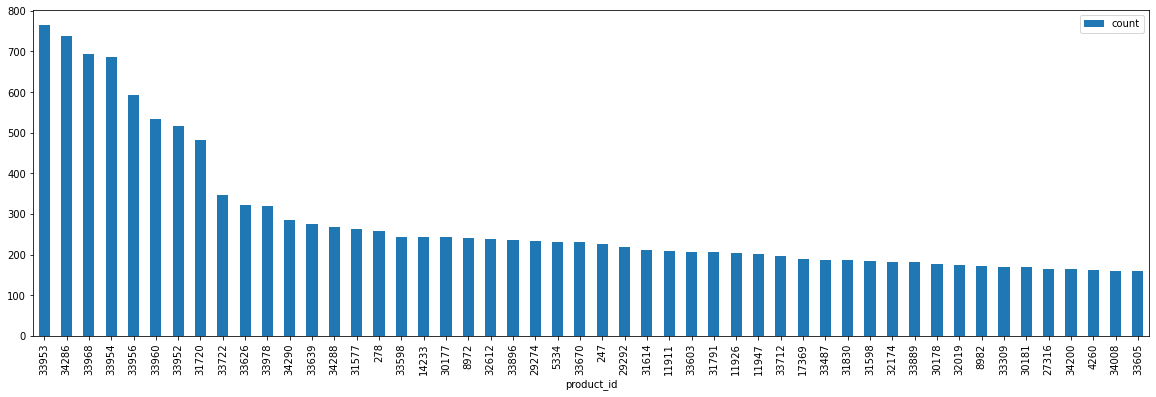

In [45]:
product_group_df.plot.bar(figsize=(20, 6), x="product_id");

## Weitere Auffälligkeiten

Jetzt wollen wir den Datensatz auf weitere Auffälligkeiten untersuchen.

### URL-Pfad-Längen

HTTP-Anfragen, die sehr lange Pfade enthalten, können für den Webserver eventuell problematisch sein, weil deren Verarbeitung hohen Rechenaufwand erzeugt.

Wir wollen deshalb herausfinden, ob der Webserver des Online-Shops Anfragen erhält, die ungewöhnlich lange Pfade enthalten. Dazu fügen wir eine neue Spalte im `DataFrame` hinzu, die mit der Anzahl der Zeichen des Pfades in der jeweiligen Zeile gefüllt wird.

In [11]:
df = df.withColumn("request_path_length", length("request_path"))

Jetzt sortieren wir die Zeilen abfallend nach der Pfadlänge, um die Anfragen mit den längsten Pfaden auslesen zu können.

In [ ]:
pandas_df = df.select("ip", "method", "request_path", "status", "request_path_length") \
  .sort(df.request_path_length.desc()) \
  .limit(20) \
  .toPandas()

In [43]:
pandas_df

,ip,method,request_path,status,request_path_length
0,91.99.30.32,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
1,91.99.47.57,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
2,91.99.30.32,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
3,5.78.190.233,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
4,91.99.30.32,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
5,91.99.30.32,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
6,91.99.47.57,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
7,5.117.116.238,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
8,151.239.241.163,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188
9,151.239.241.163,GET,/rapidGrails/jsonList?maxColumns=10&domainClas...,414,8188


Wir sehen, dass die meisten Anfragen mit den längsten Pfaden zur Route `/rapidGrails/...` gehören. Die Route wird anscheinend von dem Java Plugin „Grails“ genutzt, um große JSON-ähnlichen Datenmengen über die Query-Parameter einer `GET`-Anfrage an den Server zu übertragen. Einige dieser Anfragen wurden vom Webserver mit dem Fehlercode 414 („URI Too Long“) beantwortet. Um das Problem zu lösen, könnte man das Plugin eventuell so konfigurieren, dass die Daten im Body einer `POST`-Anfrage übertragen werden, anstatt dies über die Query-Parameter einer `GET`-Anfrage zu tun.

Jetzt wollen wir herausfinden, welche anderen Anfragen es neben denen des fehlerhaften Plugins noch gibt, die ebenfalls überdurchschnittlich lange Pfade enthalten. Dazu führen wir die Sortierung nach Pfadlänge ein weiteres Mal durch, aber ignorieren diesmal alle Pfade mit dem Schema `/rapidGrails/...`.

In [ ]:
pandas_df = df.select("ip", "method", "request_path", "status", "request_path_length") \
  .filter(~df.request_path.rlike(r'^/rapidGrails/')) \
  .sort(df.request_path_length.desc()) \
  .limit(20) \
  .toPandas()

In [48]:
pandas_df

,ip,method,request_path,status,request_path_length
0,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,301,2051
1,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,301,2051
2,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,301,2051
3,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,200,2051
4,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,200,2051
5,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,200,2051
6,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,301,2051
7,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,301,2051
8,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,200,2051
9,79.175.173.155,GET,/message/receive?Destination=982142328&Source=...,200,2051


Wie wir sehen, sind auch die Pfade der Anfragen an die Route `/message/...` relativ lang. Schauen wir uns einen dieser Pfade mal genauer an:

In [39]:
pandas_df.iloc[0].request_path

'/message/receive?Destination=982142328&Source=989131025616&ReceiveTime=1548508037.179&MsgBody=%D9%85%D8%B4%D8%AA%D8%B1%DB%8C+%D9%85%D8%AD%D8%AA%D8%B1%D9%85+%D8%A8%D9%87+%D8%A7%D8%B7%D9%84%D8%A7%D8%B9+%D9%85%DB%8C+%D8%B1%D8%B3%D8%A7%D9%86%D8%AF+%D8%AF%D8%B1+%D8%AA%D8%B4%D9%83+%D9%87%D8%A7%DB%8C+%D8%B3%D9%81%D8%A7%D8%B1%D8%B4%DB%8C+%D8%A8%D8%A7+%D8%AA%D9%88%D8%AC%D9%87+%D8%A7%DB%8C%D9%86%D9%83%D9%87+%D8%B4%D8%B1%D9%83%D8%AA+%D8%AA%D9%88%D9%84%DB%8C%D8%AF+%D9%83%D9%86%D9%86%D8%AF%D9%87+%D9%87%D8%B1+%D8%B3%D8%B1%DB%8C+%D9%BE%D8%A7%D8%B1%DA%86%D9%87+%D8%A8%D8%A7+%D8%B1%D9%86%DA%AF+%D9%88+%D8%B7%D8%B1%D8%AD+%D9%85%D8%AA%D9%81%D8%A7%D9%88%D8%AA%DB%8C+%D8%B1%D8%A7+%D8%A7%D8%B3%D8%AA%D9%81%D8%A7%D8%AF%D9%87+%D9%85%DB%8C+%D9%86%D9%85%D8%A7%DB%8C%D8%AF%D8%8C+%D8%A7%D9%85%D9%83%D8%A7%D9%86+%D9%85%D8%B4%D8%AE%D8%B5+%D9%86%D9%85%D9%88%D8%AF%D9%86+%D8%B1%D9%86%DA%AF+%D9%88+%D8%B7%D8%B1%D8%AD+%D9%BE%D8%A7%D8%B1%DA%86%D9%87+%D8%A7%D8%B2+%D9%82%D8%A8%D9%84+%D9%88%D8%AC%D9%88%D8%AF+%D9%86%D8%AF%D8%A7%D8

In dem Query-Parameter `MsgBody` wird eine persönliche Nachricht (iranisch und URL-kodiert) an einen Kunden des Online-Shops übermittelt. Diese Nachricht könnte eventuell sensible Informationen enthalten und sollte definitiv nicht im Query-String der URL enthalten sein. Stattdessen sollte für diese Funktion eine `POST`-Anfrage verwendet werden, die die zu übermittelnde Nachricht im Body enthält. So ließe sich verhindern, dass sensible Daten in einer Logdatei aufgezeichnet und dadurch leicht an unautorisierte Personen gelangen können.